P = int(input("Enter starting principle please. "))
n = int(input("Enter number of compounding periods per year. "))
r = float(input("Enter annual real return rate. e.g. 15 for 15% "))
y = int(input("Enter the amount of years. "))

FV = P * (((1 + ((r/100.0)/n)) ** (n*y)))

print ("The final amount after", y, "years is", FV)

In [4]:
import numpy as np
import pandas as pd
from bokeh.io import curdoc, output_notebook
#output_notebook()

from bokeh.models import ColumnDataSource, HoverTool, Span, Legend, Patch
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import brewer
from panel.template.theme import DarkTheme
from panel.models.markup import HTML
import panel as pn

css = '''
.bk-root .bk-tabs-header {
  background: #000000;
  border-radius: 5px;
  border: 1px black solid;
  font-size: x-large;
  background-color: black;
}

p {
  font-size: 16px;
}

li {
  font-size: 16px;
}
'''

pn.extension(raw_css=[css], sizing_mode="stretch_width")

def calc(starting_principle: float, 
         contribution_per_compounding_period: float,
         compounding_periods_per_year: int = 1, 
         real_return_rate: float = 0.05,
         num_years: int = 10) -> np.ndarray:
    
    # cleaning up user input
    starting_principle = max(0, starting_principle)
    contribution_per_compounding_period = max(0, contribution_per_compounding_period)
    compounding_periods_per_year = max(1, compounding_periods_per_year)
    real_return_rate = max(0, real_return_rate)
    num_years = max(1, num_years)
    
    n_points = int(num_years * compounding_periods_per_year)
    contributions = np.array(
        [starting_principle + i * contribution_per_compounding_period for i in range(n_points)],
        dtype = float
    )
    accrued_gains = np.zeros_like(contributions)
    gains = np.zeros_like(contributions)
    total = np.zeros_like(contributions)
    
    for i in range(n_points):
        if i == 0:
            total[i] = starting_principle
            gains[i] = 0.0
            accrued_gains[i] = 0.0
        else:
            gain = real_return_rate * total[i-1]
            gains[i] = gain
            accrued_gains[i] = accrued_gains[i-1] + gain
            total[i] = total[i-1] + contribution_per_compounding_period + gain
    
    df = pd.DataFrame({
        "years_elapsed": np.arange(0, num_years, 1/compounding_periods_per_year),
        "contributions": contributions,
        "accrued_gains": accrued_gains,
        "gains": gains,
        "total": total,
    })
    
    return df
  
def find_indices_of_multiples(starting_capital: float, df: pd.DataFrame):
    as_factor = df.total.values // starting_capital
    return 1+np.where(as_factor[1:] != as_factor[:-1])[0]

def find_doubling_points(df: pd.DataFrame,
                         starting_capital: float,
                         contribution_per_compounding_period: float) -> pd.DataFrame:
    starting_capital = contribution_per_compounding_period if starting_capital == 0 else starting_capital
    as_factor = df.total.values % starting_capital
    doubled = find_indices_of_multiples(
        contribution_per_compounding_period if starting_capital == 0 else starting_capital,
        df
    )
    return df.iloc[doubled]

def find_overtaking_point(df: pd.DataFrame,
                          contribution_per_compounding_period: float) -> pd.DataFrame:
    overtaking_idx = np.where(df.gains > contribution_per_compounding_period)[0]
    if overtaking_idx.shape[0] > 0:
        return df.iloc[overtaking_idx]
    else:
        return pd.DataFrame()

def find_points_of_interest(df: pd.DataFrame,
                            starting_capital: float,
                            contribution_per_compounding_period: float):
    doubling_points_df = find_doubling_points(
        df,
        starting_capital,
        contribution_per_compounding_period
    )
    overtaking_point_df = find_overtaking_point(
        df,
        contribution_per_compounding_period
    )
    return doubling_points_df, overtaking_point_df
    

In [5]:
def setup_parameters(which: str = 'left'):
    starting_principle = pn.widgets.FloatInput(
        name=f'Starting Capital', 
        value=100.0, 
        step=1e-1, 
        start=0, 
        end=1e9
    )

    contribution_per_compounding_period = pn.widgets.FloatInput(
        name=f'Contribution per Compounding Period', 
        value=100.0, 
        step=1e-1, 
        start=0, 
        end=1e9
    )

    compounding_periods_per_year = pn.widgets.IntInput(
        name=f'Compounding Periods per Year', 
        value=1, 
        step=1, 
        start=1, 
        end=52
    )

    real_return_rate = pn.widgets.FloatInput(
        name=f'Real Return Rate per Compounding Period', 
        value=0.04, 
        step=1e-3, 
        start=0, 
        end=1.0
    )

    num_years = pn.widgets.IntInput(
        name=f'Number of Years', 
        value=10, 
        step=1, 
        start=1, 
        end=99
    )

    return  starting_principle, \
            contribution_per_compounding_period, \
            compounding_periods_per_year, \
            real_return_rate, \
            num_years


def plot_curve(    starting_capital: float,
                   contribution_per_compounding_period: float,
                   compounding_periods_per_year: int = 1, 
                   real_return_rate: float = 0.05,
                   num_years: int = 10):

    df = calc(
        starting_capital,
        contribution_per_compounding_period,
        compounding_periods_per_year = compounding_periods_per_year,
        real_return_rate = real_return_rate,
        num_years = num_years
    )

    #curdoc().theme = 'dark_minimal'

    p = figure(
        x_range=(0, df.years_elapsed.max()), 
        y_range=(0, 1.1*df.total.max()),
        height=300
    )

    v_areas = p.varea_stack(
        stackers=['contributions', 'accrued_gains'], 
        x='years_elapsed', 
        color=brewer['Spectral'][10][3:5], 
        legend_label=['Contributions', 'Accrued Gains'], 
        source=df,
        hover_alpha=0.75,
        fill_alpha=0.5,
        hover_color=brewer['Spectral'][10][3:5],
    )
    p.add_tools(
        HoverTool(
            tooltips=[],
            mode='mouse'
        )
    )

    total_line = p.line(
        x='years_elapsed', 
        y='total', 
        line_color='red', 
        source=df,
        legend_label='Total Value',
        line_width=3
    )
    p.add_layout(total_line)
    
    doubling_points_df, overtaking_points_df = find_points_of_interest(
        df,
        starting_capital,
        contribution_per_compounding_period
    )
    if overtaking_points_df.shape[0] > 0:
        first = int(overtaking_points_df.years_elapsed.values.min())
        xs = list(
            range(first, round(df.years_elapsed.values.max())+1)
        )
        varea = p.varea(
            x=xs,
            y1=0, 
            y2=[1.1*overtaking_points_df.total.values.max()]*len(xs), 
            alpha=0.1,
            fill_color='blue',
            legend_label='Gains > Contribution'
        )
        p.add_layout(varea)
        
    if doubling_points_df.shape[0] > 0:        
        factor_points = p.scatter(
            'years_elapsed',
            'total',
            source=doubling_points_df,
            fill_alpha=1,
            fill_color='red',
            line_color='white',
            size=12,
            marker='star',
            legend_label='Multiple of Starting Capital'
        )
        p.add_layout(factor_points)
    
      
    
    p.add_tools(HoverTool(
        tooltips=[
            ('Years Since Initial Contribution',   '@years_elapsed'),
            ('Total Contributions',  '$@contributions'), 
            ('Accrued Gains', '$@accrued_gains'),
            ('Total', '$@total')
        ],
        mode='mouse'
    ))
    
    p.legend.location = "top_left"
    p.legend.orientation = "vertical"
    p.legend.background_fill_color = "#fafafa"

    p.grid.minor_grid_line_alpha = 0
    p.xaxis.axis_label = "Years Since Initial Contribution"
    p.yaxis.axis_label = "Value"
    p.toolbar.logo = None
    p.toolbar_location = None
    return  p, \
            doubling_points_df.years_elapsed.values[0] if doubling_points_df.shape[0] > 0 else None, \
            df.total.values[-1], \
            df.accrued_gains.values[-1], \
            overtaking_points_df.years_elapsed.values[0] if overtaking_points_df.shape[0] > 0 else None
    
spleft, \
cpcpleft, \
cppyleft, \
irleft, \
nyleft = setup_parameters(which='left')

spright, \
cpcpright, \
cppyright, \
irright, \
nyright = setup_parameters(which='right')

spsample, \
cpcpsample, \
cppysample, \
irsample, \
nysample = setup_parameters(which='sample')

@pn.depends(spleft, cpcpleft, cppyleft, irleft, nyleft)
def plot_left( starting_capital: float,
               contribution_per_compounding_period: float,
               compounding_periods_per_year: int = 1, 
               real_return_rate: float = 0.05,
               num_years: int = 10):
    p, \
    years_to_first_doubling, \
    total, \
    total_accrued_gains, \
    years_to_overtaking = plot_curve(    
        starting_capital,
        contribution_per_compounding_period,
        compounding_periods_per_year = compounding_periods_per_year,
        real_return_rate = real_return_rate,
        num_years = num_years,
    )
    summary = f"""## Summary
___
In this scenario:

* you would have grown your starting capital **~{round(total/starting_capital, 1)}x**.
* you would have approximately **${round(total, 2)}** after {num_years} years.
* your accrued gains would total to roughly **${round(total_accrued_gains, 2)}**.
"""
    if years_to_first_doubling:
        summary += f"* **your starting capital doubled** for the first time **after {round(years_to_first_doubling)} years**."
    if years_to_overtaking:
        summary += f"\n* the **gains realized through your {real_return_rate} real return rate** would have **surpassed your ${contribution_per_compounding_period} contributions** after **{round(years_to_overtaking)} years**."

    return pn.Column(p, summary)

@pn.depends(spright, cpcpright, cppyright, irright, nyright)
def plot_right(starting_capital: float,
               contribution_per_compounding_period: float,
               compounding_periods_per_year: int = 1, 
               real_return_rate: float = 0.05,
               num_years: int = 10):
    p, \
    years_to_first_doubling, \
    total, \
    total_accrued_gains, \
    years_to_overtaking = plot_curve(    
        starting_capital,
        contribution_per_compounding_period,
        compounding_periods_per_year = compounding_periods_per_year,
        real_return_rate = real_return_rate,
        num_years = num_years,
    )
    summary = f"""## Summary
___
In this scenario:

* you would have grown your starting capital **~{round(total/starting_capital, 1)}x**.
* you would have approximately **${round(total, 2)}** after {num_years} years.
* your accrued gains would total to roughly **${round(total_accrued_gains, 2)}**.
"""
    if years_to_first_doubling:
        summary += f"* **your starting capital doubled** for the first time **after {round(years_to_first_doubling)} years**."
    if years_to_overtaking:
        summary += f"\n* the **gains realized through your {real_return_rate} real return rate** would have **surpassed your ${contribution_per_compounding_period} contributions** after **{round(years_to_overtaking)} years**."

    return pn.Column(p, summary)

@pn.depends(spsample, cpcpsample, cppysample, irsample, nysample)
def plot_sample(   starting_capital: float,
                   contribution_per_compounding_period: float,
                   compounding_periods_per_year: int = 1, 
                   real_return_rate: float = 0.05,
                   num_years: int = 10):
    p, \
    years_to_first_doubling, \
    total, \
    total_accrued_gains, \
    years_to_overtaking = plot_curve(    
        starting_capital,
        contribution_per_compounding_period,
        compounding_periods_per_year = compounding_periods_per_year,
        real_return_rate = real_return_rate,
        num_years = num_years,
    )
    summary = f"""## Summary
___
In this scenario:

* you would have grown your starting capital **~{round(total/starting_capital, 1)}x**.
* you would have approximately **${round(total, 2)}** after {num_years} years.
* your accrued gains would total to roughly **${round(total_accrued_gains, 2)}**.
"""
    if years_to_first_doubling:
        summary += f"* **your starting capital doubled** for the first time **after {round(years_to_first_doubling)} years**."
    if years_to_overtaking:
        summary += f"\n* the **gains realized through your {real_return_rate} real return rate** would have **surpassed your ${contribution_per_compounding_period} contributions** after **{round(years_to_overtaking)} years**."

    return pn.Column(p, summary)


Traceback (most recent call last):
 File "c:\users\samy\minicond3_4.8.3\envs\streamlit-env\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "c:\users\samy\minicond3_4.8.3\envs\streamlit-env\lib\site-packages\panel\viewable.py", line 272, in _on_msg
 patch.apply_to_document(doc, comm.id)
AttributeError: 'NoneType' object has no attribute 'id'

MaterialTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] MaterialTemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [2745578117296] Tabs(align=('center', 'start'), sizing_mode='stretch_width')
        [0] Row(align='center', sizing_mode='stretch_width')
            [0] Column(align=('center', 'start'), sizing_mode='stretch_width', width_policy='min')
                [0] Markdown(str, sizing_mode='stretch_width')
            [1] Column(align=('center', 'start'), sizing_mode='stretch_width', width_policy='min')
                [0] Markdown(str, sizing_mode='stretch_width')
            [2] Column(min_width=400, sizing_mode='stretch_width', width_policy='min')
                [0] Column(align='center', sizing_mode='stretch_width')
                    [0] Markdown(str, sizing_mode='stretch_width')
                    [1] FloatInput(end=1000000000.0, name='Starting Capital', sizing_mode='stretch_width', start=0, value=100.0)
                    [2] FloatInput(end=1000000000.0, name='Contribution p..., sizing_mode='stretch_width', start=0, value=100.0)
                    [3] IntInput(end=52, name='Compounding P..., sizing_mode='stretch_width', start=1, value=1)
                    [4] FloatInput(end=1.0, name='Interest Rate', sizing_mode='stretch_width', start=0, step=0.001, value=0.04)
                    [5] IntInput(end=99, name='Number of Years', sizing_mode='stretch_width', start=1, value=10)
                [1] ParamFunction(function, sizing_mode='stretch_width')
        [1] Row(align=('center', 'start'), sizing_mode='stretch_width')
            [0] Column(align=('center', 'start'), min_width=400, sizing_mode='stretch_width')
                [0] Column(align='center', sizing_mode='stretch_width')
                    [0] Markdown(str, sizing_mode='stretch_width')
                    [1] FloatInput(end=1000000000.0, name='Starting Capital', sizing_mode='stretch_width', start=0, value=100.0)
                    [2] FloatInput(end=1000000000.0, name='Contribution p..., sizing_mode='stretch_width', start=0, value=100.0)
                    [3] IntInput(end=52, name='Compounding P..., sizing_mode='stretch_width', start=1, value=1)
                    [4] FloatInput(end=1.0, name='Interest Rate', sizing_mode='stretch_width', start=0, step=0.001, value=0.04)
                    [5] IntInput(end=99, name='Number of Years', sizing_mode='stretch_width', start=1, value=10)
                [1] ParamFunction(function, sizing_mode='stretch_width')
            [1] Spacer(background='#121212', max_width=25, min_width=25, sizing_mode='stretch_width', width_policy='min')
            [2] Column(align=('center', 'start'), min_width=400, sizing_mode='stretch_width')
                [0] Column(align='center', sizing_mode='stretch_width')
                    [0] Markdown(str, sizing_mode='stretch_width')
                    [1] FloatInput(end=1000000000.0, name='Starting Capital', sizing_mode='stretch_width', start=0, value=100.0)
                    [2] FloatInput(end=1000000000.0, name='Contribution p..., sizing_mode='stretch_width', start=0, value=100.0)
                    [3] IntInput(end=52, name='Compounding P..., sizing_mode='stretch_width', start=1, value=1)
                    [4] FloatInput(end=1.0, name='Interest Rate', sizing_mode='stretch_width', start=0, step=0.001, value=0.04)
                    [5] IntInput(end=99, name='Number of Years', sizing_mode='stretch_width', start=1, value=10)
                [1] ParamFunction(function, sizing_mode='stretch_width')
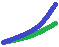

In [7]:
explanation = """# What's This?

This small web app shows the effect of different parameters (real return rate, compounding periods per year, etc...) on the growth of a savings account subject to periodic contributions.

___

Wealthsimple's curve plots were the inspiration for this project. I really appreciate their efforts to show the benefits of regularity and discipline for the growth of a savings account. However, Wealthsimple's curves don't show a few aspects that I deemed to be worth pointing out. For instance, it would be interesting to know:
  
* Which proportion of the savings' account comes from contributions versus from accrued gains?
* How long it would take to double, triple, quadruple, etc... the initial capital?
* When will the gains outgrow the contributions?

From a business perspective, I believe these items could increase customer engagement with a platform like Wealthsimple's because they demonstrate more personalized insights.


"""

explanation_part_2 = f"""# How Can I Use This Web App?

You can begin by exploring the impact of changing parameters on the plot on the right.

These parameters are:

* **Starting Capital**: how much money you're starting with.
* **Number of Years**: the number of years during which you'll be following this plan.
* **Real Return Rate per Compounding Period**: the average real return rate you're expecting per compounding period.
* **Contribution per Compounding Period**: the amount you'll be depositing into your account per compounding period.
* **Compounding Periods per Year**: how many compounding periods are in a year.

**NOTES**:
___

* The 'Real Return Rate per Compounding Period' (RR) is calculated by subtracting the inflation rate per compounding period (IR) from the nominal return rate per compounding period (NR): 
> RR = NR - IR
For example, if we assume a 2% inflation rate per compounding period (IR = 0.02) and expect that we'd make gains at a rate of 5% per compounding period (without accounting for inflation; NR = 0.05), then the real return rate per compounding period (RR) would be 
> 0.05 - 0.02 = 0.03

* The 'Compounding Periods per Year' indicates how often the real return rate is applied to the money in your account over the course of a year. 
For instance, 'Compounding Periods per Year' = 2 means that your gains made through your real return rate will be achieved on a 6-month basis.

* When 'Compounding Periods per Year' is not set to 1, it is important to ensure that the 'Real Return Rate per Compounding Period' is adjusted.
"""

pn.widgets.Select.sizing_mode = 'stretch_width'
#pn.extension(sizing_mode = 'stretch_width')

explanatory_tab = pn.Row(
    #pn.Spacer(background='#121212', min_width=10, width_policy='min'),
    pn.Column(
        explanation, 
        align=('center','start'), 
        width_policy='min'
    ), 
    #pn.Spacer(background='#121212', width=10),
    pn.Column(
        explanation_part_2,
        align=('center','start'), 
        width_policy='min'
    ),
    #pn.Spacer(background='#121212', width=10),
    pn.Column(
        pn.Column('<center><h1>Sample Chart</h1><h2>Parameters</h2></center>', spsample, cpcpsample, cppysample, irsample, nysample, align='center'), 
        plot_sample,
        min_width=400, 
        width_policy='min'
    ),
    #pn.Spacer(background='#121212', min_width=10),
    align = 'center'
)

comparative_tab = pn.Row(
    #pn.Spacer(background='#121212', max_width=25),
    pn.Column(
        pn.Column('<h2><center>Scenario A</center></h2>', spleft, cpcpleft, cppyleft, irleft, nyleft, align='center'), 
        plot_left,
        min_width=400,
        align=('center','start')
    ),
    pn.Spacer(background='#121212', max_width=25, min_width=25, width_policy='min'),
    pn.Column(
        pn.Column('<h2><center>Scenario B</center></h2>', spright, cpcpright, cppyright, irright, nyright, align='center'), 
        plot_right,
        min_width=400,
        align=('center','start')
    ),
    #pn.Spacer(background='#121212', max_width=25),
    align = ('center', 'start')
)

template = pn.template.MaterialTemplate(
    title='Wealthsimple+', 
    theme=DarkTheme, 
    #logo = 'iVBORw0KGgoAAAANSUhEUgAAADsAAAA2CAIAAAD22XY6AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAAGESURBVGhD7di9UcQwEIZhQQm0QAmkDkgJoA8qIKUVWoCAlMApJRBRiPmYFRqxsldrW78zegPfhs/srOfm7mJZFtNVl/azn4Y4f0OcvyHOX3/iDr5Bbu8+afh4v8Gz9R07LqJ53HHS/AW72hWH3KbveIuLxh2nSFgwak4sc9G4inNFF4waEmu4aFzF0ZQLRk2I9VxUXxxy5SqLV7nCglFzb57MRTXFu87XVe1Xk557/XpPw9fDG551dqx822B1XERzBbHybfOtfqXFGi5bLavcHW9dgs8VoIjuuJA4ytVYqexi4SUjrmxFPhflFcvcvVYqlziHlUovFqzo+/HZThsx6zzPdjJmmiY8U4qTWH1iGNBpxLIVRbkvV092EjsrjkJRKit1XFzeio7csQaKZOvepdrpL624mDUksiJiJRQdtkaJrHVxVuheIuufWA9FgpVBTxJZVnx+qU6Z1hf2K9ZwV6GkzE1kxcXMCmVhImtT7KDViSx+x4C2RmRZcUc19y9WJGN+AMaw8zGXcBEeAAAAAElFTkSuQmCC'
    logo = r"logo.png"
)

app = pn.Tabs(
    ('Explanation', explanatory_tab), 
    ('Comparing Scenarios', comparative_tab),
    align = ('center', 'start')
)

template.main.append(app)
template.servable()

#asapp = pn.panel(golden, sizing_mode="stretch_width")
#asapp.servable()
#asapp